# ArchR Integration

scATAC + scRNA integration using ArchR.

**TODO**: Run with right set of cells!! And use SnapATAC dim reduction!

In [1]:
library(Seurat)
library(ArchR)
library(rtracklayer)
library(patchwork)

Loading required package: ggplot2

Loading required package: SummarizedExperiment

Loading required package: GenomicRanges

Loading required package: stats4

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    unio

In [2]:
addArchRThreads(threads = 32) 

Setting default number of Parallel threads to 32.



In [3]:
addArchRGenome("hg38")

Setting default genome to Hg38.



## Load Data

In [4]:
ArrowFiles = c('D0.arrow',
               'D2.arrow',
               'D4.arrow',
               'D6.arrow',
               'D8.arrow',
               'D10.arrow',
               'D12.arrow',
               'D14.arrow',
               'iPSC.arrow')

In [5]:
archr_proj <- ArchRProject(
  ArrowFiles = paste("/srv/scratch/surag/scATAC-reprog/arrow/", ArrowFiles, sep=''), 
  outputDirectory = "./tmp/",
  copyArrows = FALSE #This is recommened so that you maintain an unaltered copy for later usage.
)

Using GeneAnnotation set by addArchRGenome(Hg38)!

Using GeneAnnotation set by addArchRGenome(Hg38)!

Validating Arrows...

Getting SampleNames...



Getting Cell Metadata...



Merging Cell Metadata...

Initializing ArchRProject...


                                                   / |
                                                 /    \
            .                                  /      |.
            \\\                              /        |.
              \\\                          /           `|.
                \\\                      /              |.
                  \                    /                |\
                  \\#####\           /                  ||
                ==###########>      /                   ||
                 \\##==......\    /                     ||
            ______ =       =|__ /__                     ||      \\\
        ,--' ,----`-,__ ___/'  --,-`-===================##========>
       \               '        ##_______ _____ ,-

### Seurat Object

In [6]:
rna = readRDS("../20200828_RNA_Seurat/sessions/20210725_n59378/seurat.rds")
rna$tech = "rna"

In [7]:
peak_set = import("../20200206_pmat_snapATAC/sessions/20210717_n62599/peaks.bed")
peak_set

GRanges object with 530910 ranges and 0 metadata columns:
           seqnames            ranges strand
              <Rle>         <IRanges>  <Rle>
       [1]    chr17 32960818-32961317      *
       [2]    chr17 75764253-75764752      *
       [3]    chr17   1473115-1473614      *
       [4]    chr17   4206898-4207397      *
       [5]    chr17     423410-423909      *
       ...      ...               ...    ...
  [530906]     chrY   7260942-7261441      *
  [530907]     chrY 13337358-13337857      *
  [530908]     chrY   7109992-7110491      *
  [530909]     chrY 13241192-13241691      *
  [530910]     chrY   7936007-7936506      *
  -------
  seqinfo: 24 sequences from an unspecified genome; no seqlengths

In [151]:
# Metadata file from previous run
# should contain, sample_barcode as rowname, sample, umap1, umap2, cluster
metaData = read.table("../20200206_pmat_snapATAC/sessions/20210717_n62599/metadata.tsv", header = T)
rownames(metaData) = paste(metaData$sample, metaData$barcode, sep='_')
metaData$cells = rownames(metaData) # for cicero
dim(metaData)
head(metaData, 5)

[1] 62599     6

barcode          sample umap1      umap2     cluster
D0_AAACACGCTAGTACGG AAACACGCTAGTACGG D0     -1.8037916 -9.507773 1      
D0_AAACACGCTCTTCAAG AAACACGCTCTTCAAG D0      0.7074551 -9.406457 1      
D0_AAACACGCTGATCCAT AAACACGCTGATCCAT D0     -2.9559933 -7.641148 1      
D0_AAACCCTGACCGCTAG AAACCCTGACCGCTAG D0     -3.6119107 -8.443144 1      
D0_AAACCCTGATTGCAGT AAACCCTGATTGCAGT D0      0.5002119 -8.759449 3      
                    cells              
D0_AAACACGCTAGTACGG D0_AAACACGCTAGTACGG
D0_AAACACGCTCTTCAAG D0_AAACACGCTCTTCAAG
D0_AAACACGCTGATCCAT D0_AAACACGCTGATCCAT
D0_AAACCCTGACCGCTAG D0_AAACCCTGACCGCTAG
D0_AAACCCTGATTGCAGT D0_AAACCCTGATTGCAGT

In [10]:
# atac.feats = read.table("../20200206_pmat_snapATAC/sessions/20201022_n53906/features.8d.tsv", sep='\t', header=T)
# rownames(atac.feats) = atac.feats$sample_barcode
# atac.feats$sample_barcode = NULL
# head(atac.feats)

In [11]:
# subset to cells used
all(sub("_", "#", rownames(metaData)) %in% archr_proj$cellNames)

[1] TRUE

In [12]:
archr_proj = archr_proj[sub("_", "#", rownames(metaData)), ]

In [13]:
archr_proj


           ___      .______        ______  __    __  .______      
          /   \     |   _  \      /      ||  |  |  | |   _  \     
         /  ^  \    |  |_)  |    |  ,----'|  |__|  | |  |_)  |    
        /  /_\  \   |      /     |  |     |   __   | |      /     
       /  _____  \  |  |\  \\___ |  `----.|  |  |  | |  |\  \\___.
      /__/     \__\ | _| `._____| \______||__|  |__| | _| `._____|
    



class: ArchRProject 
outputDirectory: /users/surag/kundajelab/scATAC-reprog/src/analysis/20200925_Peak2Gene/tmp 
samples(9): D0 D2 ... D14 iPSC
sampleColData names(1): ArrowFiles
cellColData names(15): Sample TSSEnrichment ... DoubletEnrichment
  BlacklistRatio
numberOfCells(1): 62599
medianTSS(1): 11.468
medianFrags(1): 10913

## ArchR Prep

In [14]:
# add peaks matrix 
archr_proj = addPeakSet(archr_proj, peak_set)
archr_proj <- addPeakMatrix(archr_proj)

ArchR logging to : ArchRLogs/ArchR-addPeakMatrix-10352e2e710119-Date-2021-08-27_Time-01-16-38.log
If there is an issue, please report to github with logFile!

2021-08-27 01:16:40 : Batch Execution w/ safelapply!, 0 mins elapsed.

ArchR logging successful to : ArchRLogs/ArchR-addPeakMatrix-10352e2e710119-Date-2021-08-27_Time-01-16-38.log



In [15]:
getAvailableMatrices(archr_proj)

[1] "GeneScoreMatrix" "PeakMatrix"      "TileMatrix"

In [16]:
archr_proj <- addIterativeLSI(
    ArchRProj = archr_proj,
    useMatrix = "PeakMatrix", 
    name = "IterativeLSI", 
    iterations = 2, 
    clusterParams = list( #See Seurat::FindClusters
        resolution = c(0.2), 
        sampleCells = 10000, 
        n.start = 10
    ), 
    varFeatures = 25000, 
    dimsToUse = 1:30
)

Checking Inputs...

ArchR logging to : ArchRLogs/ArchR-addIterativeLSI-10352e3b986cc9-Date-2021-08-27_Time-01-20-31.log
If there is an issue, please report to github with logFile!

2021-08-27 01:20:35 : Computing Total Across All Features, 0.038 mins elapsed.

2021-08-27 01:20:40 : Computing Top Features, 0.126 mins elapsed.

###########
2021-08-27 01:20:42 : Running LSI (1 of 2) on Top Features, 0.161 mins elapsed.
###########

2021-08-27 01:20:42 : Sampling Cells (N = 10004) for Estimated LSI, 0.162 mins elapsed.

2021-08-27 01:20:43 : Creating Sampled Partial Matrix, 0.163 mins elapsed.

2021-08-27 01:20:55 : Computing Estimated LSI (projectAll = FALSE), 0.366 mins elapsed.

2021-08-27 01:21:57 : Identifying Clusters, 1.406 mins elapsed.

2021-08-27 01:22:22 : Identified 5 Clusters, 1.818 mins elapsed.

2021-08-27 01:22:22 : Saving LSI Iteration, 1.818 mins elapsed.

2021-08-27 01:22:45 : Creating Cluster Matrix on the total Group Features, 2.202 mins elapsed.

2021-08-27 01:22:59 :

In [17]:
archr_proj <- addUMAP(ArchRProj = archr_proj, reducedDims = "IterativeLSI")

01:24:59 UMAP embedding parameters a = 0.7669 b = 1.223

01:24:59 Read 62599 rows and found 30 numeric columns

01:24:59 Using Annoy for neighbor search, n_neighbors = 40

01:24:59 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*

|

01:25:11 Writing NN index file to temp file /tmp/Rtmp5TdvMj/file10352e75642645

01:25:12 Searching Annoy index using 28 threads, search_k = 4000

01:25:14 Annoy recall = 100%

01:25:14 Commencing smooth kNN distance calibration using 28 threads

01:25:18 Initializing from normalized Laplacian + noise

01:25:23 Commencing optimization for 200 epochs, with 3965196 positive edges

01:26:07 Optimization finished

01:26:07 Creating temp model dir /tmp/Rtmp5TdvMj/dir10352e6915b5c

01:26:07 Creating dir /tmp/Rtmp5TdvMj/dir10352e6915b5c

01:26:13 Chan

In [18]:
archr_proj$Clusters = factor(metaData$cluster)

In [19]:
# archr_proj <- addClusters(input = archr_proj, reducedDims = "IterativeLSI")

In [20]:
p1 <- plotEmbedding(ArchRProj = archr_proj, colorBy = "cellColData", name = "Sample", embedding = "UMAP")
p2 <- plotEmbedding(ArchRProj = archr_proj, colorBy = "cellColData", name = "Clusters", embedding = "UMAP")

ArchR logging to : ArchRLogs/ArchR-plotEmbedding-10352e2a8bbba3-Date-2021-08-27_Time-01-26-15.log
If there is an issue, please report to github with logFile!

Getting UMAP Embedding

ColorBy = cellColData

Plotting Embedding

1 


ArchR logging successful to : ArchRLogs/ArchR-plotEmbedding-10352e2a8bbba3-Date-2021-08-27_Time-01-26-15.log

ArchR logging to : ArchRLogs/ArchR-plotEmbedding-10352e7c301ae0-Date-2021-08-27_Time-01-26-18.log
If there is an issue, please report to github with logFile!

Getting UMAP Embedding

ColorBy = cellColData

Plotting Embedding

1 


ArchR logging successful to : ArchRLogs/ArchR-plotEmbedding-10352e7c301ae0-Date-2021-08-27_Time-01-26-18.log



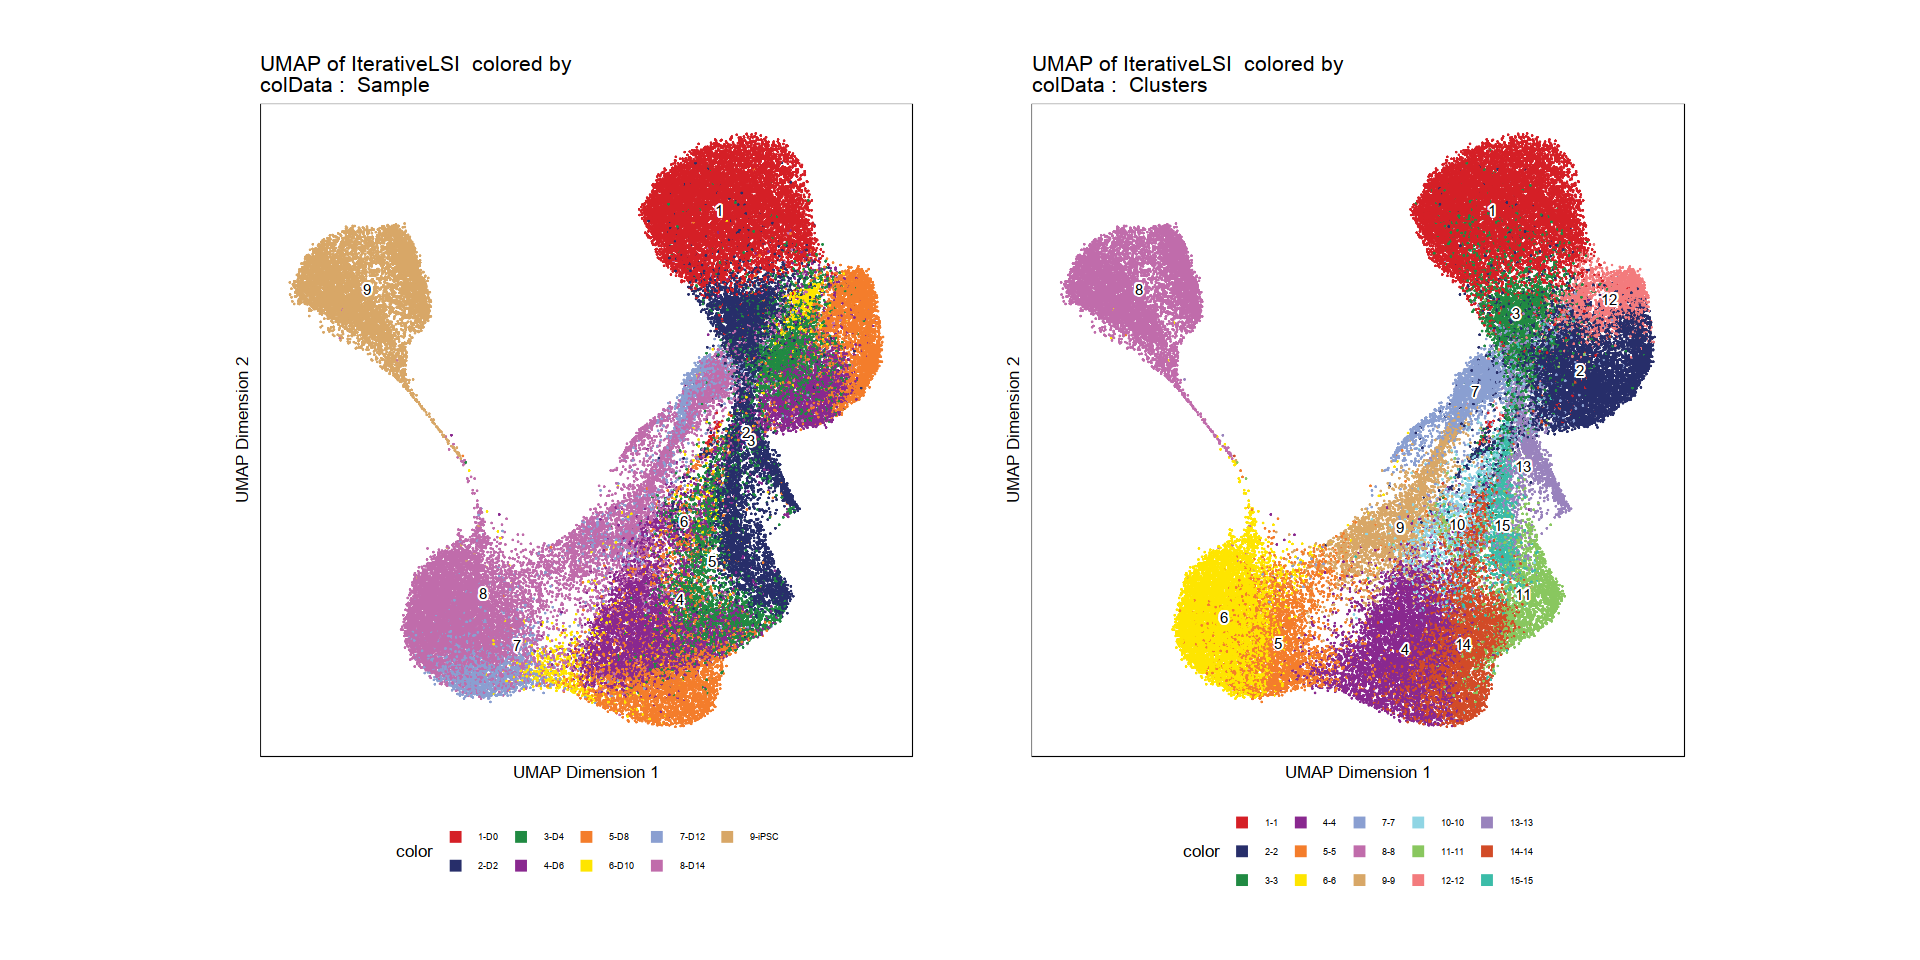

In [21]:
options(repr.plot.width = 16, repr.plot.height = 8)

p1 | p2

## Integration

In [22]:
archr_proj <- addGeneIntegrationMatrix(
    ArchRProj = archr_proj, 
    useMatrix = "GeneScoreMatrix",
    matrixName = "GeneIntegrationMatrix",
    reducedDims = "IterativeLSI",
    seRNA = rna,
    addToArrow = T,
    groupRNA = "seurat_clusters",
    nameCell = "predictedCell_Un",
    nameGroup = "predictedGroup_Un",
    nameScore = "predictedScore_Un",
    force = T
)

ArchR logging to : ArchRLogs/ArchR-addGeneIntegrationMatrix-10352e46b052a3-Date-2021-08-27_Time-01-29-15.log
If there is an issue, please report to github with logFile!

2021-08-27 01:29:16 : Running Seurat's Integration Stuart* et al 2019, 0.026 mins elapsed.

2021-08-27 01:29:21 : Checking ATAC Input, 0.098 mins elapsed.

2021-08-27 01:29:21 : Checking RNA Input, 0.098 mins elapsed.

2021-08-27 01:29:43 : Found 19672 overlapping gene names from gene scores and rna matrix!, 0.462 mins elapsed.

2021-08-27 01:29:43 : Creating Integration Blocks, 0.462 mins elapsed.

2021-08-27 01:29:46 : Prepping Interation Data, 0.516 mins elapsed.

2021-08-27 01:29:50 : Computing Integration in 6 Integration Blocks!, 0 mins elapsed.

2021-08-27 01:38:06 : Block (1 of 6) : Plotting Joint UMAP, 8.276 mins elapsed.

Length of unique values greater than palette, interpolating..

2021-08-27 01:38:46 : Block (2 of 6) : Plotting Joint UMAP, 8.937 mins elapsed.

Length of unique values greater than palette, 

In [23]:
getAvailableMatrices(archr_proj)

[1] "GeneIntegrationMatrix" "GeneScoreMatrix"       "PeakMatrix"           
[4] "TileMatrix"

In [98]:
gi_mat = getMatrixFromProject(archr_proj, "GeneIntegrationMatrix")

ArchR logging to : ArchRLogs/ArchR-getMatrixFromProject-10352e444056dc-Date-2021-08-27_Time-02-45-14.log
If there is an issue, please report to github with logFile!

2021-08-27 02:47:15 : Organizing colData, 2.016 mins elapsed.

2021-08-27 02:47:15 : Organizing rowData, 2.019 mins elapsed.

2021-08-27 02:47:15 : Organizing rowRanges, 2.02 mins elapsed.

2021-08-27 02:47:15 : Organizing Assays (1 of 1), 2.02 mins elapsed.

2021-08-27 02:48:39 : Constructing SummarizedExperiment, 3.412 mins elapsed.

2021-08-27 02:48:42 : Finished Matrix Creation, 3.462 mins elapsed.



In [141]:
head(gi_mat@elementMetadata)

DataFrame with 6 rows and 6 columns
  seqnames   start     end  strand      name     idx
     <Rle> <array> <array> <array>   <array> <array>
1     chr1   69091   70008       1     OR4F5       1
2     chr1  817371  819837       1    FAM87B       2
3     chr1  825138  859446       1 LINC01128       3
4     chr1  827522  826206       2 LINC00115       4
5     chr1  876903  868071       2    FAM41C       5
6     chr1  919692  916870       2 LINC02593       6

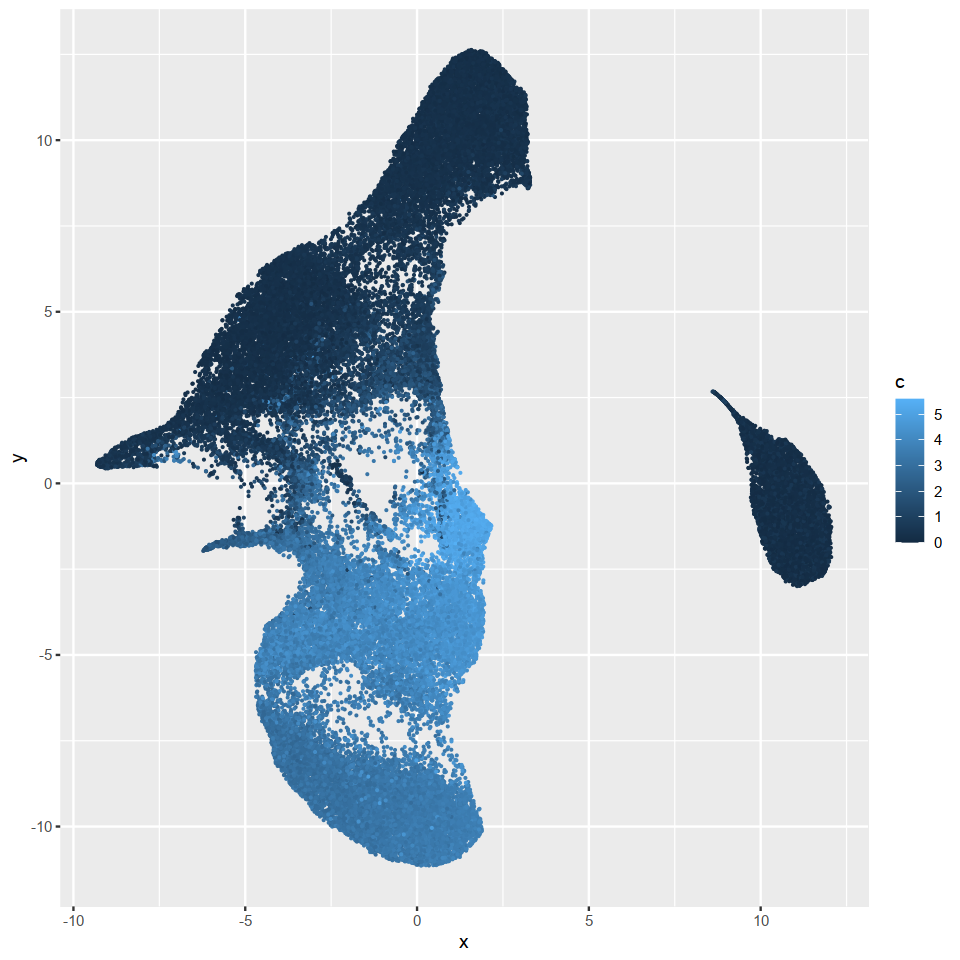

In [153]:
ggplot(data.frame(x=metaData$umap1, y=metaData$umap2, 
                 c=log(1+assay(gi_mat)[which(gi_mat@elementMetadata$name=="COL1A1"),][sub("_", "#", rownames(metaData))]))) +
geom_point(aes(x=x,y=y,color=c), size=0.1)

Warning message:
“Using `as.character()` on a quosure is deprecated as of rlang 0.3.0.
Please use `as_label()` or `as_name()` instead.
This warning is displayed once per session.”


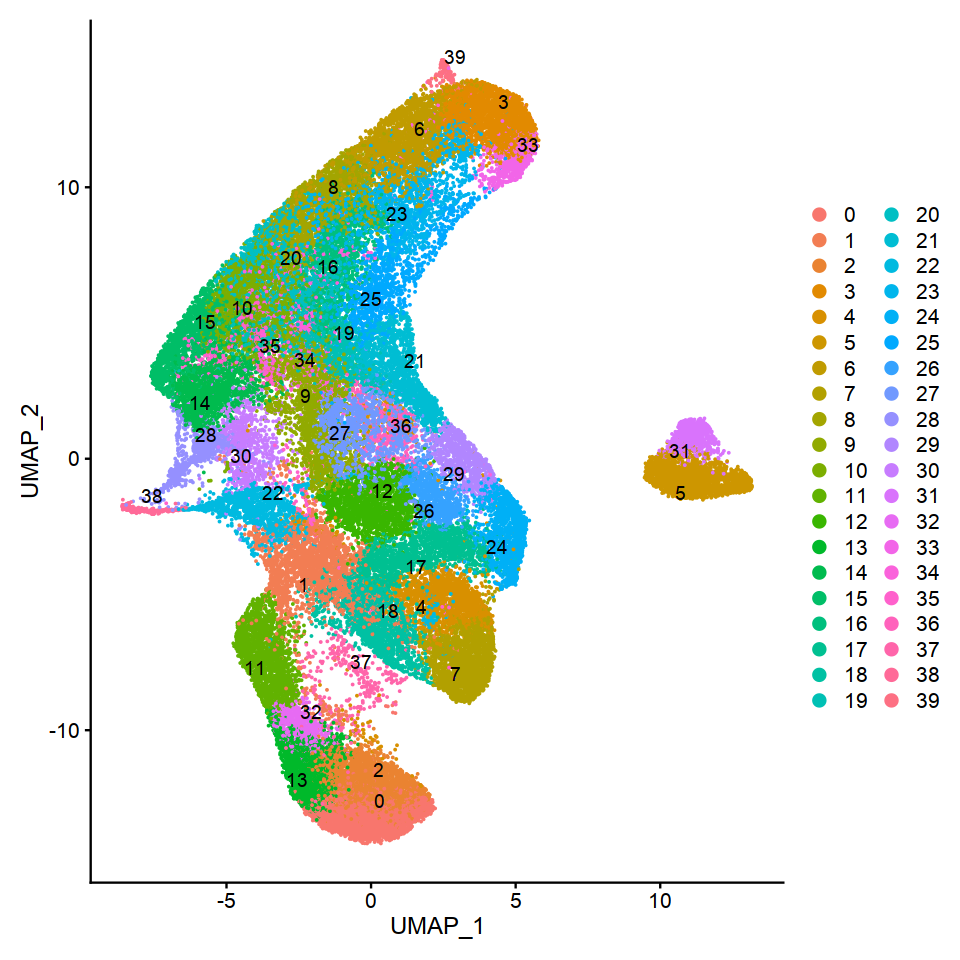

In [24]:
options(repr.plot.width = 8, repr.plot.height = 8)

DimPlot(rna, group.by="seurat_clusters", label=T, repel=T) 

In [25]:
cM <- as.matrix(confusionMatrix(archr_proj$Clusters, archr_proj$predictedGroup_Un))
preClust <- colnames(cM)[apply(cM, 1 , which.max)]
cbind(preClust, rownames(cM)) #Assignments

preClust   
 [1,] 0        1 
 [2,] 11       3 
 [3,] 7        2 
 [4,] 14       11
 [5,] 17       12
 [6,] 28       15
 [7,] 20       4 
 [8,] 24       7 
 [9,] 21       9 
[10,] 6        5 
[11,] 15       14
[12,] 9        10
[13,] 22       13
[14,] 3        6 
[15,] 5        8

In [26]:
head(rev(sort(table(archr_proj$predictedCell_Un))), 20)


CTAACTTCAGCAGTGA-9 TTGAGTGGTAGGTTTC-1 CATCCGTCAGACAAGC-9 TCGGATATCGTAGCTA-9 
              1175                642                465                459 
TGGATCAGTGAACTAA-1 GTTTACTCACCGTGCA-1 GTTGTCCGTCATCGGC-8 GCGTTTCAGTAGATCA-1 
               413                413                410                399 
CAAGACTAGATTAGAC-1 ACAAAGAAGGATATGT-9 GGGTTATCATCCTCAC-8 GCATGATTCACGAACT-1 
               383                371                364                341 
TCAGTGAAGATAGCAT-1 CCACGAGCATTCTCCG-7 TCCGAAAAGAGTCGAC-9 ATCACTTAGTATGTAG-8 
               337                320                318                315 
ACTACGACAGTCCGTG-8 GAAGGACTCACCATGA-1 TTTCCTCAGACTACCT-1 TCAGTGAAGTACCCTA-1 
               315                281                276                256 

In [160]:
BARCODE = "AATGGCTGTGTTCCTC-3"

In [161]:
umap_dims = archr_proj@embeddings$UMAP$df
colnames(umap_dims) = c("UMAP1", "UMAP2")
umap_dims$col = archr_proj$predictedCell_Un %in% c(BARCODE)
umap_dims$sz = ifelse(umap_dims$col, 10, 1)
umap_dims = umap_dims[order(umap_dims$sz), ]

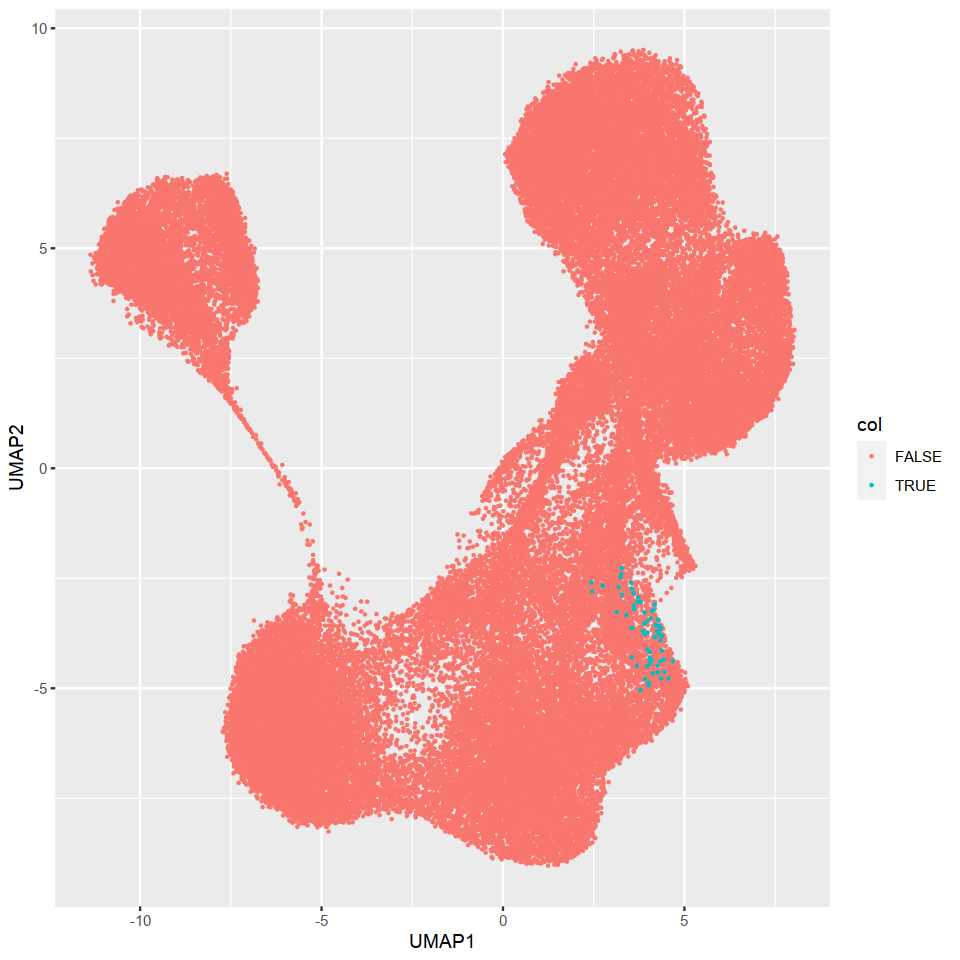

In [162]:
ggplot(umap_dims) + 
geom_point(aes(x=UMAP1, y=UMAP2, col=col), stroke=0, size=1)

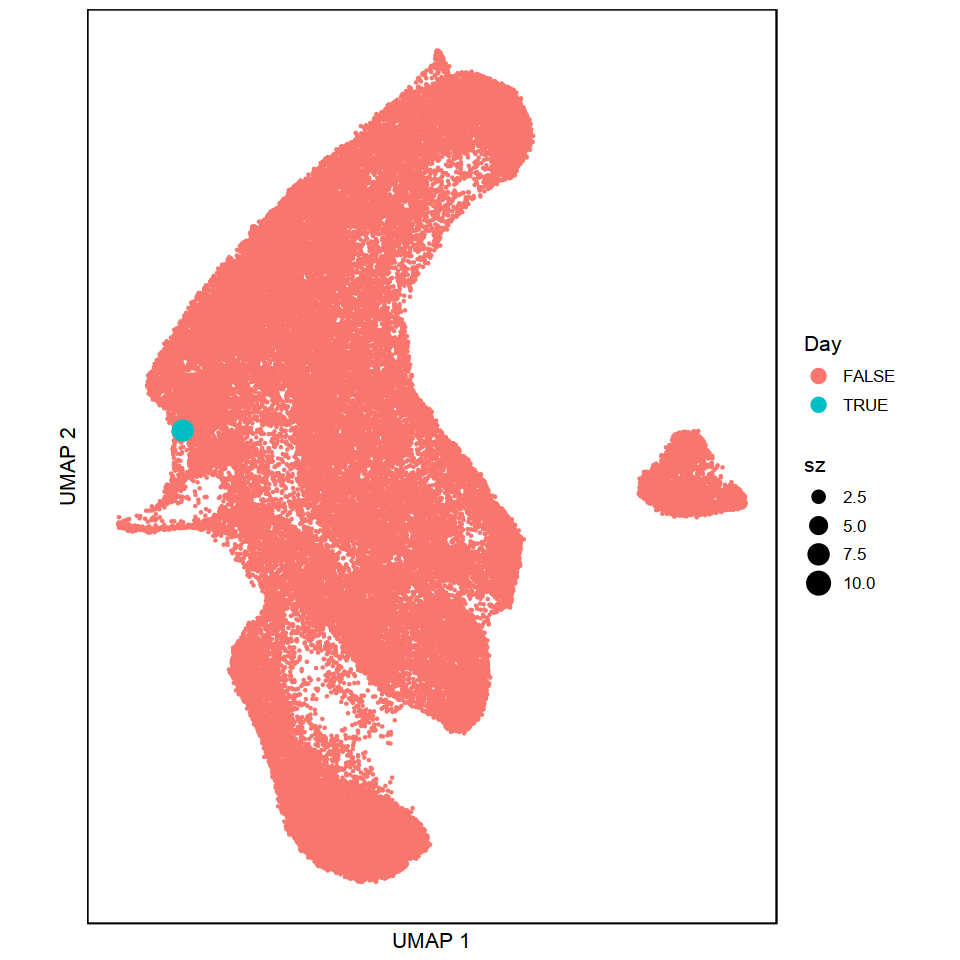

In [163]:
plot_df <- data.frame(pc1=data.frame(Embeddings(rna, reduction='umap'))$UMAP_1,
                 pc2=data.frame(Embeddings(rna, reduction='umap'))$UMAP_2,
                 col=colnames(rna) %in% c(BARCODE))
plot_df$sz = ifelse(plot_df$col, 10, 1)
plot_df = plot_df[order(plot_df$sz), ]

by_day <- ggplot(plot_df) +
geom_point(aes(x=pc1, y=pc2, color=col, stroke=0, size=sz)) +
theme_classic() +
xlab("UMAP 1") + ylab("UMAP 2") +
theme(plot.title = element_text(hjust = 0.5),
      text = element_text(size=12),
      axis.line=element_blank(),
      axis.text.x=element_blank(),
      axis.text.y=element_blank(),
      axis.ticks=element_blank(),
      panel.border = element_rect(colour = "black", fill=NA, size=0.5)) +
guides(colour = guide_legend(title="Day",
     override.aes = list(shape=16, alpha=1, size=4))) + 
coord_fixed()

by_day

In [31]:
archr_proj <- addPeak2GeneLinks(
    ArchRProj = archr_proj,
    reducedDims = "IterativeLSI"
)

ArchR logging to : ArchRLogs/ArchR-addPeak2GeneLinks-10352e7142444d-Date-2021-08-27_Time-01-45-56.log
If there is an issue, please report to github with logFile!

2021-08-27 01:45:58 : Getting Available Matrices, 0.033 mins elapsed.

2021-08-27 01:46:05 : Filtered Low Prediction Score Cells (13374 of 62599, 0.214), 0.064 mins elapsed.

2021-08-27 01:46:09 : Computing KNN, 0.126 mins elapsed.

2021-08-27 01:46:10 : Identifying Non-Overlapping KNN pairs, 0.143 mins elapsed.

2021-08-27 01:46:13 : Identified 500 Groupings!, 0.185 mins elapsed.

2021-08-27 01:46:13 : Getting Group RNA Matrix, 0.186 mins elapsed.

2021-08-27 01:46:45 : Getting Group ATAC Matrix, 0.73 mins elapsed.

2021-08-27 01:48:11 : Normalizing Group Matrices, 2.16 mins elapsed.

2021-08-27 01:48:33 : Finding Peak Gene Pairings, 2.532 mins elapsed.

2021-08-27 01:48:34 : Computing Correlations, 2.548 mins elapsed.

2021-08-27 01:49:29 : Completed Peak2Gene Correlations!, 3.465 mins elapsed.

ArchR logging successful to 

In [32]:
p2g <- getPeak2GeneLinks(
    ArchRProj = archr_proj,
    corCutOff = -1,
    FDRCutOff = 1e-04,
    resolution = 1,
    returnLoops = FALSE
)

In [33]:
sum(p2g$Correlation < -0.45)

[1] 40589

In [34]:
p2g

DataFrame with 738992 rows and 6 columns
         idxATAC    idxRNA        Correlation                  FDR
       <integer> <integer>          <numeric>            <numeric>
1             50         3 -0.215862771007605 3.37815249976247e-06
2             60         3  0.201344071300312 1.60548264346599e-05
3             76         3  0.191876487666504 4.17257136067042e-05
4             81         3 -0.187259159728839 6.53420000697823e-05
5             87         3 -0.185196237893727 7.95600625489295e-05
...          ...       ...                ...                  ...
738988    530041     19672  0.312569689184891 4.65748846980523e-12
738989    530042     19672  0.233206771465183 4.50415847107704e-07
738990    530044     19672   0.19539113148389 2.94279827330441e-05
738991    530046     19672  0.192757249312541 3.82554249254117e-05
738992    530049     19672 -0.269177675971592 3.97852464471157e-09
                VarQATAC           VarQRNA
               <numeric>         <numeric>
1 

In [217]:
## peak_gene_ct["CTCFL"]

In [35]:
head(p2g@metadata[[1]])

GRanges object with 6 ranges and 0 metadata columns:
      seqnames      ranges strand
         <Rle>   <IRanges>  <Rle>
  [1]     chr1  9928-10427      *
  [2]     chr1 11136-11635      *
  [3]     chr1 13271-13770      *
  [4]     chr1 15430-15929      *
  [5]     chr1 15991-16490      *
  [6]     chr1 21248-21747      *
  -------
  seqinfo: 24 sequences from an unspecified genome; no seqlengths

In [36]:
p2g@metadata[[2]][p2g$idxRNA]

GRanges object with 738992 ranges and 2 metadata columns:
           seqnames    ranges strand |      name     idx
              <Rle> <IRanges>  <Rle> |   <array> <array>
       [1]     chr1    825138      * | LINC01128       3
       [2]     chr1    825138      * | LINC01128       3
       [3]     chr1    825138      * | LINC01128       3
       [4]     chr1    825138      * | LINC01128       3
       [5]     chr1    825138      * | LINC01128       3
       ...      ...       ...    ... .       ...     ...
  [738988]     chrX 155669944      * |     TMLHE     716
  [738989]     chrX 155669944      * |     TMLHE     716
  [738990]     chrX 155669944      * |     TMLHE     716
  [738991]     chrX 155669944      * |     TMLHE     716
  [738992]     chrX 155669944      * |     TMLHE     716
  -------
  seqinfo: 23 sequences from an unspecified genome; no seqlengths

In [165]:
# write to file
p2g_df = data.frame(p2g)
peaks_to_write = (p2g@metadata[[1]][p2g$idxATAC])
start(peaks_to_write) = start(peaks_to_write) - 1 # adjusting to match bed file
p2g_df$peak = as.character(peaks_to_write)
p2g_df$gene = p2g@metadata[[2]][p2g$idxRNA]$name

p2g_df$idxATAC = NULL
p2g_df$idxRNA = NULL   

p2g_df = p2g_df[, c("peak", "gene", "Correlation", "FDR", "VarQATAC", "VarQRNA")]

head(p2g_df)

write.table(p2g_df, "./peak2gene_links/RNA_20210725_n59378_ATAC_20210717_n62599/20210826_all_fdr1e-4.tsv",
           sep='\t', quote=F, col.names=T, row.names=F)

peak               gene      Correlation FDR          VarQATAC  VarQRNA  
1 chr1:585929-586429 LINC01128 -0.2158628  3.378152e-06 0.8456104 0.4633998
2 chr1:737946-738446 LINC01128  0.2013441  1.605483e-05 0.5514626 0.4633998
3 chr1:826825-827325 LINC01128  0.1918765  4.172571e-05 0.8919647 0.4633998
4 chr1:845596-846096 LINC01128 -0.1872592  6.534200e-05 0.5450585 0.4633998
5 chr1:858621-859121 LINC01128 -0.1851962  7.956006e-05 0.7429790 0.4633998
6 chr1:906705-907205 LINC01128  0.5794615  1.330099e-44 0.9578667 0.4633998

In [185]:
pred_rna_df = data.frame(barcode=sub("#", "_", rownames(archr_proj)),
                         pred_RNA=archr_proj$predictedCell_Un)
rownames(pred_rna_df) = pred_rna_df$barcode
pred_rna_df = pred_rna_df[rownames(metaData),]
head(pred_rna_df)

write.table(pred_rna_df, "./peak2gene_links/RNA_20210725_n59378_ATAC_20210717_n62599/20210826_atac_closest_rna_pred.tsv",
           sep='\t', quote=F, col.names=T, row.names=F)

barcode             pred_RNA          
D0_AAACACGCTAGTACGG D0_AAACACGCTAGTACGG GATCCCTCACCAGCCA-1
D0_AAACACGCTCTTCAAG D0_AAACACGCTCTTCAAG CAAGACTAGATTAGAC-1
D0_AAACACGCTGATCCAT D0_AAACACGCTGATCCAT GCGTTTCAGTAGATCA-1
D0_AAACCCTGACCGCTAG D0_AAACCCTGACCGCTAG TTGCTGCCACAACGAG-4
D0_AAACCCTGATTGCAGT D0_AAACCCTGATTGCAGT CCCTAACTCGACATTG-1
D0_AAACCGTACACACCTA D0_AAACCGTACACACCTA TGGATCAGTGAACTAA-1

In [178]:
data.frame(head(rownames(archr_proj))

[1] "D0#AAACACGCTAGTACGG" "D0#AAACACGCTCTTCAAG" "D0#AAACACGCTGATCCAT"
[4] "D0#AAACCCTGACCGCTAG" "D0#AAACCCTGATTGCAGT" "D0#AAACCGTACACACCTA"

In [176]:
# gi_mat_to_write = assay(gi_mat)
# rownames(gi_mat_to_write) = gi_mat@elementMetadata$name
# colnames(gi_mat_to_write) = sub("#", "_", colnames(gi_mat_to_write))
# all(rownames(metaData) %in% colnames(gi_mat_to_write))
# gi_mat_to_write = gi_mat_to_write[, rownames(metaData)]
# gi_mat_to_write[1:10,1:10]

In [177]:
# writeMM(gi_mat_to_write, "./peak2gene_links/RNA_20210725_n59378_ATAC_20210717_n62599/gene_integration_mat.mm")

In [96]:
sum(p2g_df[abs(p2g_df$Correlation)>0.4,"gene"]=="NANOG")

[1] 54

In [90]:
head(rev(sort(table(p2g_df[abs(p2g_df$Correlation)>0.4,]$gene))), 20)


COL6A3   MLPH  FOXF1  TNNI3  EIF3K  SMAD3  HOXB3  TNNT1  HOXB5   NAV1  HOXB6 
   105     94     86     82     82     81     79     78     78     77     77 
 GCNT2 FENDRR   FUT2  HOXB7  ABCA7  HOXB4 COL1A1   F11R   NFIC 
    77     77     76     75     75     74     74     73     72 

In [42]:
length(unique(p2g_df$gene))

[1] 14743

In [43]:
length(unique(p2g_df$peak))

[1] 256363

In [44]:
median(table(p2g_df$gene))

[1] 48

---

In [41]:
sessionInfo()

R version 3.6.3 (2020-02-29)
Platform: x86_64-conda_cos6-linux-gnu (64-bit)
Running under: Ubuntu 18.04.5 LTS

Matrix products: default
BLAS/LAPACK: /users/surag/anaconda3/envs/r36_cran/lib/libopenblasp-r0.3.9.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
 [1] grid      parallel  stats4    stats     graphics  grDevices utils    
 [8] datasets  methods   base     

other attached packages:
 [1] gtable_0.3.0                      gridExtra_2.3                    
 [3] uwot_0.1.8                        nabor_0.5.0                      
 [5] BSgenome.Hsapiens.UCSC.hg38_1.4.1 BSgenome_1.54.0                  
 [7] Biostrings_2.54.0                 XVect

Stuff below not run recently.

## Characterizing Positive and Negative Correlation Links

In [16]:
p2g_df = read.table("./peak2gene_links/RNA_20200913_n59369/ATAC_20201022_n53906/20200925_all_fdr1e-4.tsv",
                   header=T)
head(p2g_df)

peak               gene      Correlation FDR          VarQATAC  VarQRNA  
1 chr1:839897-840397 FAM87B     0.2477269  7.719952e-08 0.1893802 0.1702327
2 chr1:916486-917542 FAM87B     0.2473330  8.122994e-08 0.8509143 0.1702327
3 chr1:850279-850795 LINC01128 -0.2134423  4.650652e-06 0.5427712 0.4374512
4 chr1:857838-859165 LINC01128 -0.2534247  3.659260e-08 0.8104871 0.4374512
5 chr1:906668-907523 LINC01128  0.2939716  1.028522e-10 0.8878045 0.4374512
6 chr1:911064-912074 LINC01128  0.2201864  2.189101e-06 0.7773968 0.4374512

In [20]:
gene_sets = list()
for (i in seq(10)) {
    gene_sets[[i]] = as.character(read.table(sprintf("../20200828_RNA_Seurat/gene_sets/20201012_tmp_gridmap_znorm_n10/idx%d.txt", i))$V1)
}

In [21]:
gene_set_sizes = unlist(lapply(gene_sets, length))
gene_set_sizes

[1] 324 506 554 422 329 212 657 345 251 445

In [22]:
head(gene_sets[[1]])

[1] "HES4"    "ISG15"   "TNFRSF4" "MMP23B"  "GPR153"  "TNFRSF9"

In [23]:
top_pos_genes = p2g_df[p2g_df$Correlation>0.45, "gene"]
top_neg_genes = p2g_df[p2g_df$Correlation < -0.45, "gene"]

# top_pos_genes = p2g_df[rev(order(p2g_df$Correlation)), "gene"][1:10000]
# top_neg_genes = p2g_df[order(p2g_df$Correlation), "gene"][1:10000]

In [24]:
pos_tot = c()
neg_tot = c()

for (i in seq(10)){
    pos_tot = c(pos_tot, sum(top_pos_genes %in% gene_sets[[i]]))
    neg_tot = c(neg_tot, sum(top_neg_genes %in% gene_sets[[i]]))
}

In [25]:
pos_tot

[1] 2652 5524 7388 3570 2530  572 7127 1365 1768 4215

In [36]:
neg_tot

[1]  237  908 1688  155   26   30 2373 1008  348  471

In [26]:
pos_tot/sum(pos_tot)

[1] 0.07223993 0.15047261 0.20124758 0.09724606 0.06891667 0.01558116
 [7] 0.19413800 0.03718232 0.04815995 0.11481572

In [27]:
neg_tot/sum(neg_tot)

[1] 0.032716731 0.125345113 0.233020431 0.021397018 0.003589177 0.004141358
 [7] 0.327581447 0.139149641 0.048039757 0.065019326

In [28]:
pos_tot
neg_tot

[1] 2652 5524 7388 3570 2530  572 7127 1365 1768 4215

[1]  237  908 1688  155   26   30 2373 1008  348  471

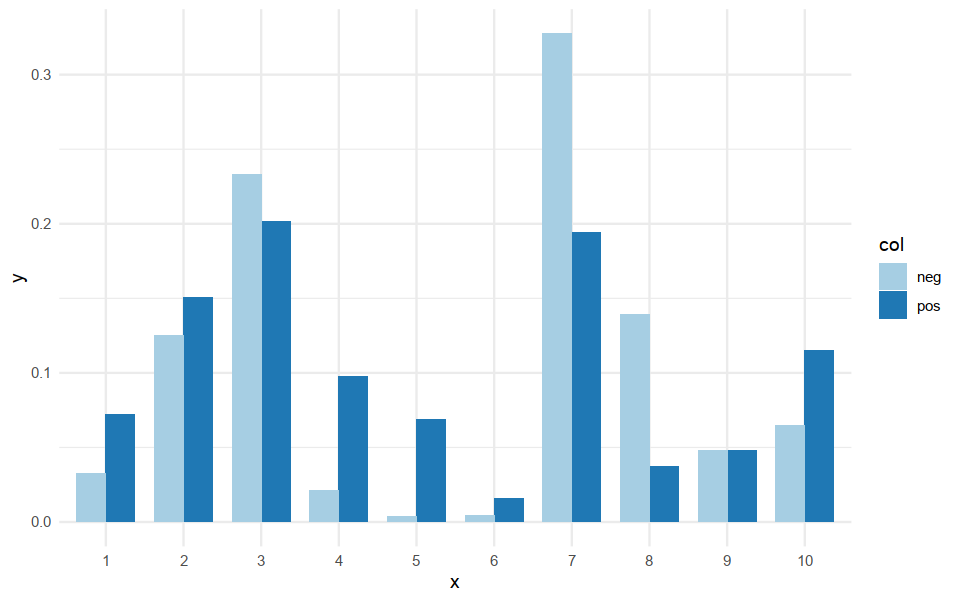

In [30]:
options(repr.plot.width = 8, repr.plot.height = 5)

ggplot(data.frame(x=factor(rep(seq(10),2)),
                 y=c(pos_tot/sum(pos_tot), neg_tot/sum(neg_tot)),
                 col = c(rep("pos", 10), rep("neg", 10))),
      aes(x=x,y=y, fill=col)) +
geom_bar(stat="identity", width=0.75, position=position_dodge()) +
scale_fill_brewer(palette="Paired")+
  theme_minimal()

In [31]:
pos_tot_adjust = 100*pos_tot/gene_set_sizes
neg_tot_adjust = 100*neg_tot/gene_set_sizes

In [ ]:
quantile(as.vector(rna[["RNA"]]["OAS1"])[rna$sample != "D0"], .95)

In [382]:
median(as.vector(rna[["RNA"]]["MYC"])[rna$sample != "D0"][as.vector(rna[["RNA"]]["OAS1"])[rna$sample != "D0"] > 1])

[1] 0

In [381]:
median(as.vector(rna[["RNA"]]["MYC"])[rna$sample != "D0"][as.vector(rna[["RNA"]]["OAS1"])[rna$sample != "D0"] < 1])

[1] 1.898708

In [33]:
head(rev(sort(table(top_neg_genes[top_neg_genes %in% unlist(gene_sets)]))), 100)


 SLC25A33    ISYNA1      TSR1      RRAS  SH3BGRL3     TCOF1     NINJ1  HSP90AB1 
       27        27        26        25        24        23        23        23 
  TMEM160     RRP1B      PVT1       MYC      IL34    SNRPA1     MTFP1     CMSS1 
       22        22        22        22        21        20        20        20 
   MRPS23     VAMP8    PCOLCE     MED15   LAPTM4B     FCGRT       DDT     RPL12 
       19        18        18        18        18        18        18        17 
     RCC2   FAM207A      DCP2     CCND1  SERPINB9    SCNN1A    NEURL1     MXRA8 
       17        17        17        17        16        16        16        16 
     LRP8     KDM1A     HOXB5      EMP3     CDCA5     WDR43      USP7      RMI2 
       16        16        16        16        16        15        15        15 
    PARVB       MIF     HOXB6     FADS1      ETV4     EPPK1     CENPV  C19orf33 
       15        15        15        15        15        15        15        15 
  AKIRIN1    A4GALT    TIMM

In [34]:
head(rev(sort(table(top_neg_genes[top_neg_genes %in% gene_sets[[7]]]))), 50)


   ISYNA1  HSP90AB1   TMEM160      PVT1      IL34    MRPS23     MED15   LAPTM4B 
       27        23        22        22        21        19        18        18 
      DDT     RPL12      RCC2   FAM207A      DCP2  SERPINB9    NEURL1      LRP8 
       18        17        17        17        17        16        16        16 
    KDM1A     PARVB       MIF      ETV4     EPPK1  C19orf33    A4GALT    TIMM8B 
       16        15        15        15        15        15        15        14 
    SUSD2  PPARGC1B      JAG1     ITGB2      GCH1  SLC39A10     SALL4    POU5F1 
       14        14        14        14        14        13        13        13 
     DFFA    TYMSOS     TPST2     SNHG4    SCARB1     RPS28     RPS23     RPS12 
       13        12        12        12        12        12        12        12 
    REEP6     PTAR1 LINC01260   GNPNAT1      DENR      CNBP     CDCA7 TTC28-AS1 
       12        12        12        12        12        12        12        11 
   SPINT2   SELENOW 
      

In [35]:
head(rev(sort(table(top_neg_genes[top_neg_genes %in% gene_sets[[8]]]))), 50)


SLC25A33     TSR1    TCOF1    RRP1B   SNRPA1    MTFP1    CMSS1    CDCA5 
      27       26       23       22       20       20       20       16 
   WDR43     USP7     RMI2    CENPV   RSL1D1   MRPS12   ATAD3B    CEBPZ 
      15       15       15       15       14       14       13       12 
  TOMM40     TFAM   SERBP1    PAM16    MYBL2   MRPL18     CYCS     CDC6 
      11       11       11       11       11       11       11       11 
    TCP1    SRSF7   RUVBL1     MCM5   EIF4A3     CDT1   CD3EAP    CD320 
      10       10       10       10       10       10       10       10 
   NOP16   GRPEL1    C1QBP   TIMM10    SURF2   SNHG17    ITGA6    FKBP4 
       9        9        9        8        8        8        8        8 
   DHX33    UBE2T    TOMM6   TIMM50   RPL39L   RANBP1     PIF1     NPM1 
       8        7        7        7        7        7        7        7 
    NIFK   MRPL12 
       7        7 

In [417]:
table(top_neg_genes)["SALL4"]
table(top_pos_genes)["SALL4"]

SALL4 
   13

SALL4 
   14

In [369]:
cor(as.vector(rna[["RNA"]]["COL1A1"])[rna$sample == "D2"], 
    as.vector(rna[["RNA"]]["MYC"])[rna$sample == "D2"])

[1] -0.4109809

In [383]:
subset = c(1,2,3,7,8,9,10)
pos_tot_adjust[subset]/sum(pos_tot_adjust[subset])
neg_tot_adjust[subset]/sum(neg_tot_adjust[subset])

[1] 0.12837901 0.17122559 0.20916193 0.17014019 0.06205533 0.11047755 0.14856041

[1] 0.05026890 0.12331940 0.20939135 0.24821523 0.20078788 0.09527996 0.07273726

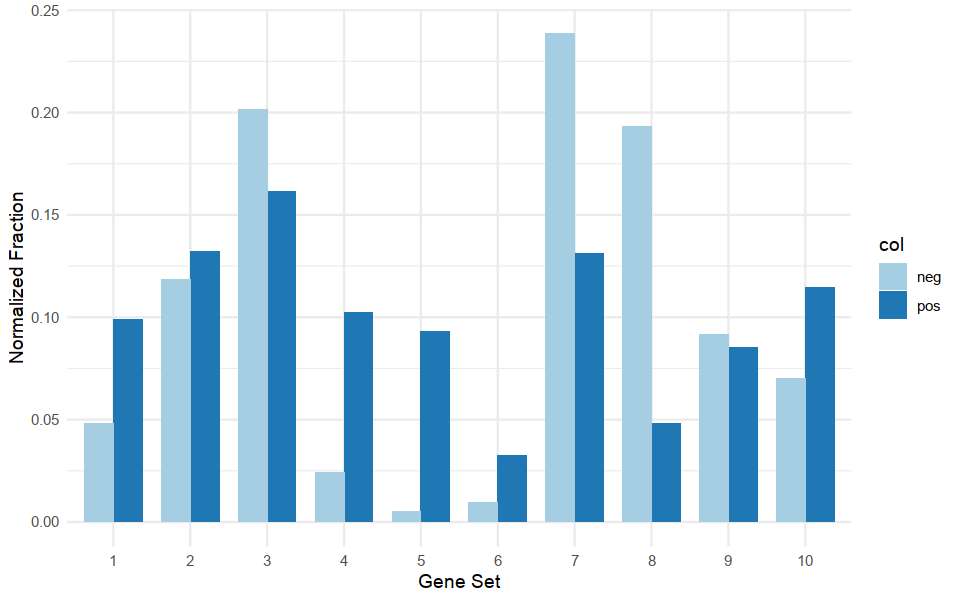

In [424]:
options(repr.plot.width = 8, repr.plot.height = 5)

ggplot(data.frame(x=factor(rep(seq(10),2)),
                 y=c(pos_tot_adjust/sum(pos_tot_adjust), neg_tot_adjust/sum(neg_tot_adjust)),
                 col = c(rep("pos", 10), rep("neg", 10))),
      aes(x=x,y=y, fill=col)) +
xlab("Gene Set") + ylab("Normalized Fraction") +
geom_bar(stat="identity", width=0.75, position=position_dodge()) +
  scale_fill_brewer(palette="Paired")+
  theme_minimal()

In [251]:
length(top_pos_genes)

[1] 93001

---

In [108]:
head(rev(sort(table(p2g$idxATAC))))


378240 378248 378252 378231 337478 337475 
    15     14     13     13     13     13 

In [109]:
head(p2g@metadata[[2]])

GRanges object with 6 ranges and 2 metadata columns:
      seqnames    ranges strand |      name     idx
         <Rle> <IRanges>  <Rle> |   <array> <array>
  [1]     chr1    817371      * |    FAM87B       1
  [2]     chr1    825138      * | LINC01128       2
  [3]     chr1    827522      * | LINC00115       3
  [4]     chr1    876903      * |    FAM41C       4
  [5]     chr1    919692      * | LINC02593       5
  [6]     chr1    924880      * |    SAMD11       6
  -------
  seqinfo: 23 sequences from an unspecified genome; no seqlengths

In [115]:
head(rev(sort(table(p2g_df$gene))), 30)


  COL6A3     MLPH   SEMA6A    PARVA    FOXF1    SMAD3    GCNT2    TNNI3 
      66       50       49       49       49       48       48       47 
    DKK3     TBX2     NAV1   FENDRR   MICAL2     JPH1  ZFP36L1     EXT1 
      47       45       44       44       43       43       42       42 
  UNC93A   TNFSF9      TNC TBX2-AS1  SLC39A4    FOXL1     UGT8    IL1R1 
      41       40       40       40       40       40       39       39 
  COL1A1   ZNF486   TUBB4A  ST6GAL1     RYR1     RXRA 
      39       38       38       38       38       38 

In [117]:
table(p2g@metadata[[2]][p2g$idxRNA]$name)["JAKMIP"]

MAP2 
  26

In [139]:
getPeak2GeneLinks(archr_proj)[[1]][queryHits(findOverlaps(getPeak2GeneLinks(archr_proj)[[1]], 
                                                          GRanges(c("chr12:7787794-7799141"))))]

GRanges object with 82 ranges and 2 metadata columns:
       seqnames          ranges strand |             value                  FDR
          <Rle>       <IRanges>  <Rle> |         <numeric>            <numeric>
   [1]    chr12 7667500-7891500      * |  0.55062494438884 2.68719331246967e-39
   [2]    chr12 7677500-7891500      * | 0.482594892547855 3.98821626156944e-29
   [3]    chr12 7678500-7891500      * | 0.497486498708443 3.69684621111592e-31
   [4]    chr12 7679500-7891500      * | 0.472772419885563 7.71042634745979e-28
   [5]    chr12 7693500-7891500      * | 0.594741248489826 2.85581593073272e-47
   ...      ...             ...    ... .               ...                  ...
  [78]    chr12 7787500-7982500      * | 0.468881731262359 2.42567986427967e-27
  [79]    chr12 7787500-8018500      * | 0.512509915437053 2.57785107855091e-33
  [80]    chr12 7787500-8019500      * | 0.664463158153499 9.80223350748262e-63
  [81]    chr12 7789500-7891500      * | 0.639733572190767 8.69238

In [100]:
p <- plotPeak2GeneHeatmap(ArchRProj = archr_proj, groupBy = "Clusters")

ArchR logging to : ArchRLogs/ArchR-plotPeak2GeneHeatmap-732172634f49-Date-2020-09-23_Time-12-19-52.log
If there is an issue, please report to github with logFile!

2020-09-23 12:20:04 : Determining KNN Groups!, 0.198 mins elapsed.

2020-09-23 12:20:19 : Ordering Peak2Gene Links!, 0.448 mins elapsed.

Warning message:
“did not converge in 10 iterations”
2020-09-23 12:22:15 : Constructing ATAC Heatmap!, 2.384 mins elapsed.

Adding Annotations..

Preparing Main Heatmap..

2020-09-23 12:22:17 : Constructing RNA Heatmap!, 2.414 mins elapsed.

Adding Annotations..

Preparing Main Heatmap..

ArchR logging successful to : ArchRLogs/ArchR-plotPeak2GeneHeatmap-732172634f49-Date-2020-09-23_Time-12-19-52.log



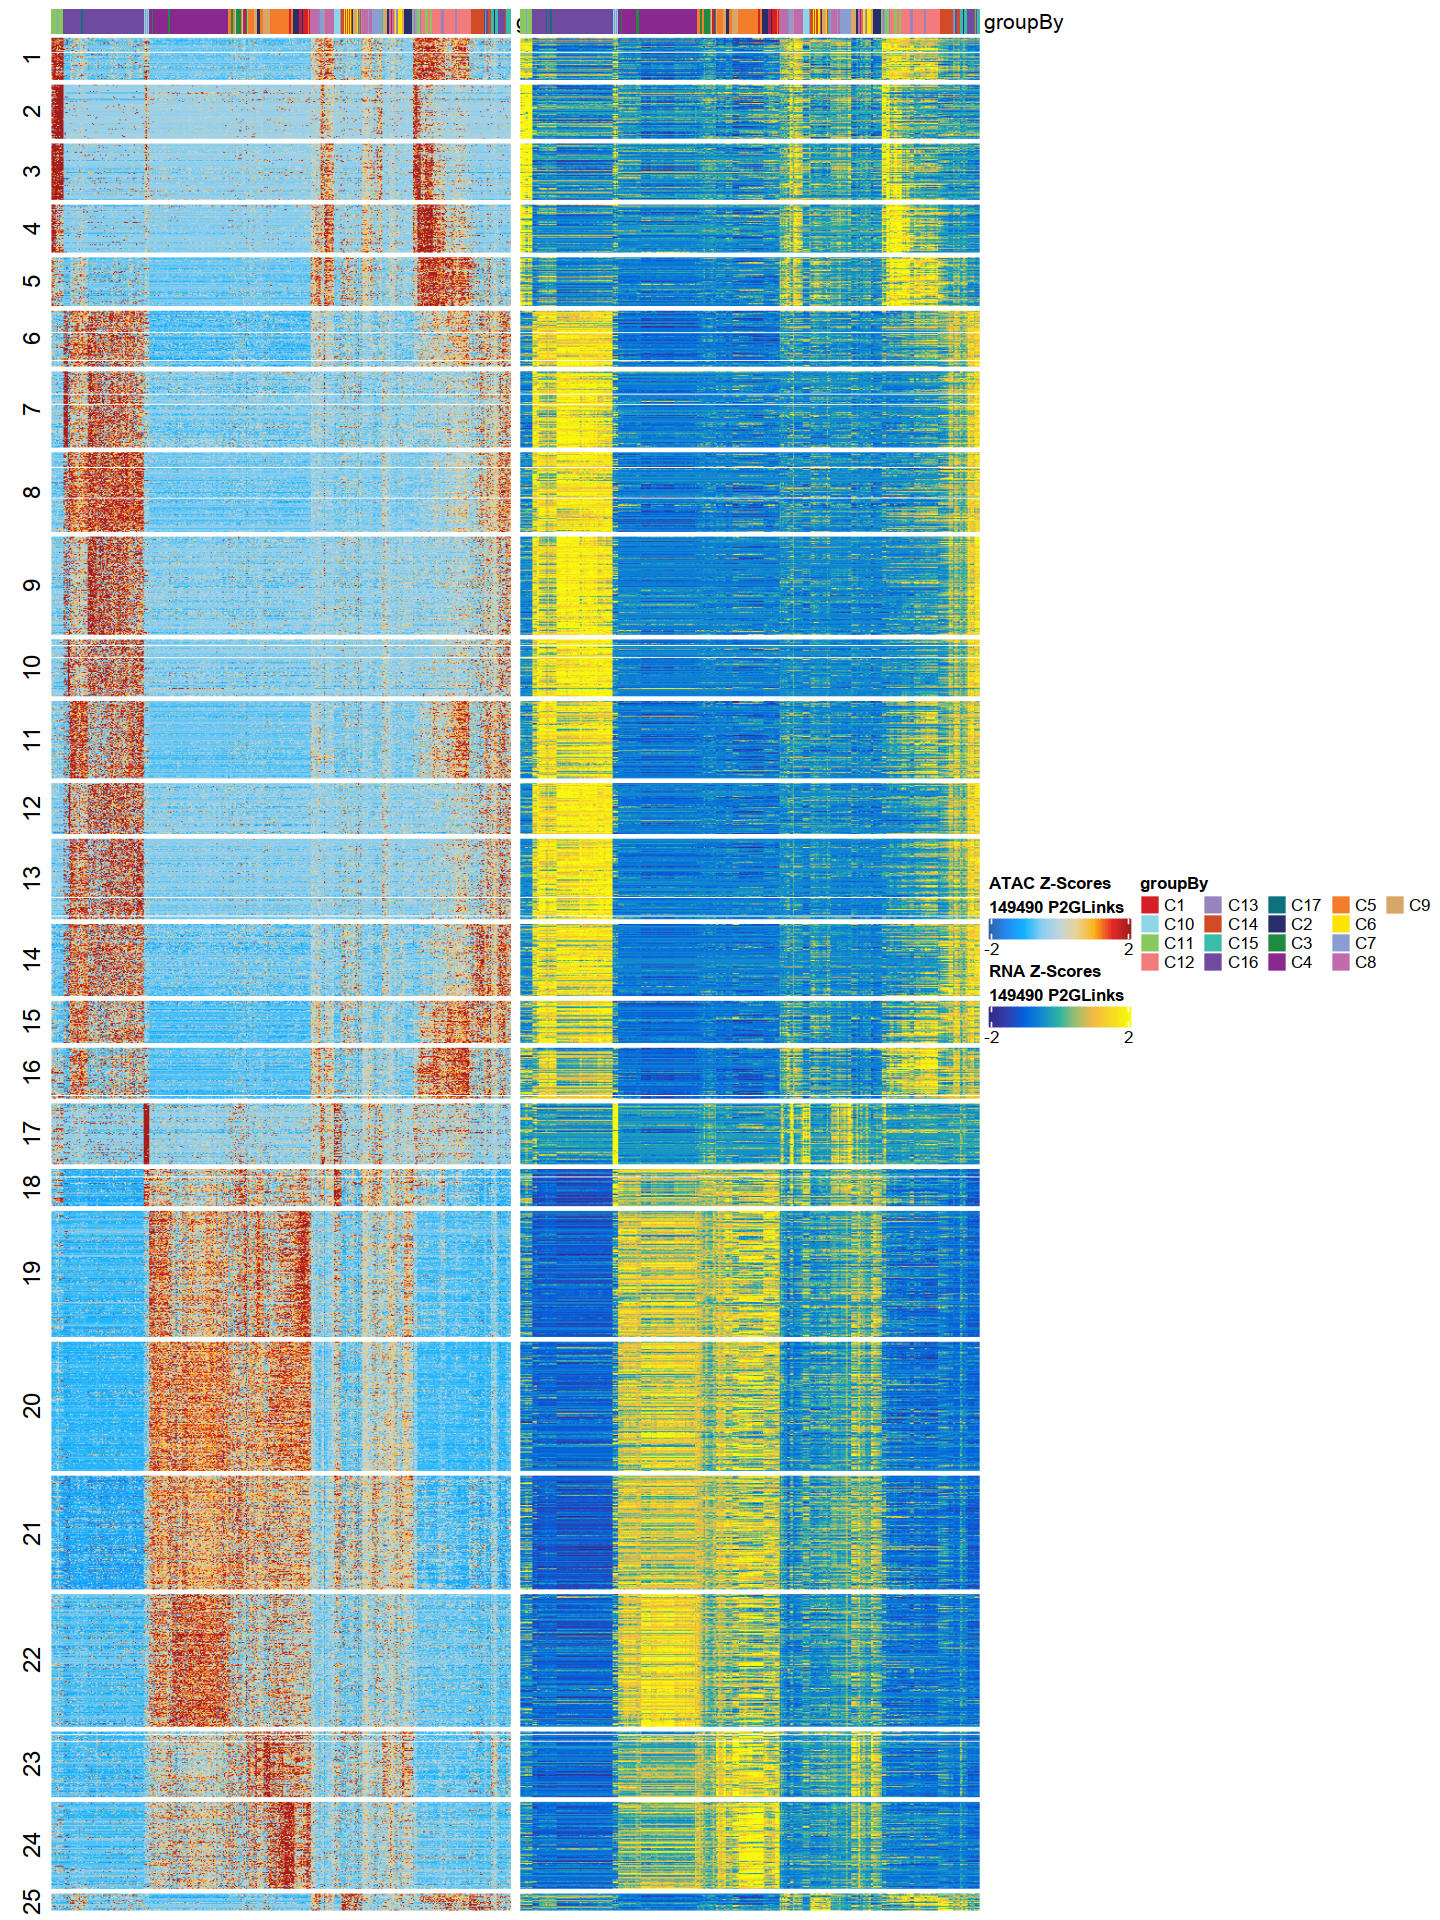

In [102]:
options(repr.plot.width = 12, repr.plot.height = 16)

p

In [258]:
p2g@metadata[[1]]

GRanges object with 803958 ranges and 1 metadata column:
           seqnames            ranges strand |  peak_set
              <Rle>         <IRanges>  <Rle> | <numeric>
       [1]     chr1       10506-10717      * |         0
       [2]     chr1       42146-42371      * |         0
       [3]     chr1       46218-46443      * |         0
       [4]     chr1       48626-48825      * |         0
       [5]     chr1       51437-51661      * |         0
       ...      ...               ...    ... .       ...
  [803954]     chrY 25399178-25399400      * |         0
  [803955]     chrY 26315152-26315361      * |         0
  [803956]     chrY 26409423-26409622      * |         0
  [803957]     chrY 26671003-26671239      * |         0
  [803958]     chrY 26671290-26671489      * |         0
  -------
  seqinfo: 24 sequences from an unspecified genome; no seqlengths

In [287]:
p2g@metadata[[1]]$peak_set = 0
all_peak_str = as.character(p2g@metadata[[1]]) # sorted version of peak_set

for (i in seq(40)) {
    cur_peak_set = import(sprintf("../20200307_fine_clustering/beds/20200705_gridmap_peakwidthnorm_logplusznorm_4way_ordered_n40/idx%d.bed", i))
    p2g@metadata[[1]][all_peak_str %in% as.character(cur_peak_set)]$peak_set = i
}

In [514]:
SELECT_PEAK_SETS = c(33,34,35)

In [515]:
idxs = which(p2g@metadata[[1]]$peak_set %in% SELECT_PEAK_SETS)

In [516]:
length(idxs)

[1] 41689

In [517]:
sum(p2g$idxATAC %in% idxs)

[1] 10289

In [518]:
p2g@metadata[[2]][p2g[p2g$idxATAC %in% idxs, ][rev(order(p2g[p2g$idxATAC %in% idxs, ]$Correlation)),]$idxRNA]

GRanges object with 10289 ranges and 2 metadata columns:
          seqnames    ranges strand |    name     idx
             <Rle> <IRanges>  <Rle> | <array> <array>
      [1]     chr1 161038962      * |    F11R    1365
      [2]     chr3  11137093      * |    HRH1      61
      [3]    chr17  48593961      * |   HOXB5     698
      [4]    chr17  48604992      * |   HOXB6     696
      [5]     chr2 238848032      * |  TWIST2    1244
      ...      ...       ...    ... .     ...     ...
  [10285]     chr7  24758113      * |   GSDME     126
  [10286]    chr10  97334709      * |   FRAT2     494
  [10287]     chr1 109283186      * |   PSRC1     949
  [10288]    chr16    684528      * |   JMJD8      37
  [10289]     chr5  38608354      * |    LIFR     124
  -------
  seqinfo: 23 sequences from an unspecified genome; no seqlengths

In [519]:
cor_genes = rev(sort(table(p2g@metadata[[2]][p2g[p2g$idxATAC %in% idxs, ]$idxRNA]$name)))
length(cor_genes)
head(cor_genes, 20)

[1] 4528


    GAMT   MALAT1   FAM89B CDC42EP2    MXRA8   SHKBP1   LGALS1    ERCC1 
      24       17       17       16       15       14       14       14 
   CIRBP  CCDC85B  TRAPPC1    LZTS2     LMNA     FIBP    TIMP2   SORBS3 
      14       14       13       13       13       13       12       12 
  PDLIM2    NEAT1     LTBR    GAPDH 
      12       12       12       12 

In [520]:
# genes ranked by correlation to their linked peak
# cor_genes_by_cor = p2g[p2g$idxATAC %in% idxs, ]
# cor_genes_by_cor = p2g@metadata[[2]][cor_genes_by_cor[rev(order(cor_genes_by_cor$Correlation)),]$idxRNA]$name
# cor_genes_by_cor = unique(cor_genes_by_cor)
# length(cor_genes_by_cor)
# head(cor_genes_by_cor, 10)

In [521]:
sum(cor_genes>1)

[1] 2312

In [524]:
cor_genes["CTCFL"]

CTCFL 
    1

In [513]:
write.table(names(cor_genes)[1:2000], "tmp.txt", quote=F, row.names=F, col.names=F)

In [478]:
# load bulk RNA-seq data
fpkm = read.table("/users/surag/kundajelab/scATAC-reprog/resources/GSE62777/RNAseq.FPKM.tsv", sep='\t', header=T)
fpkm$gene_id = NULL
fpkm$locus=NULL
tpm = fpkm
tpm[,2:ncol(tpm)] = 1e6*t(t(tpm[,2:ncol(tpm)])/colSums(tpm[,2:ncol(tpm)]))

# removing genes with dup names
tpm = tpm[!duplicated(tpm$gene_short_name),]
rownames(tpm) = tpm$gene_short_name
tpm$gene_short_name = NULL

tpm["GAPDH",]

hiF.T_P14 X2dd_DOX_plus X5dd_DOX_plus X8dd_DOX_plus
GAPDH 7803.64   4963.505      3908.693      3839.776     
      X10dd_DOX_plus_SSEA3_pos X14dd_DOX_plus_SSEA3_pos X20dd_DOX_plus_TRA_plus
GAPDH 3795.548                 3364.503                 3032.412               
      X24dd_TRA_pos_DOX_plus X24dd_TRA_pos_DOX_minus hIPSC.T_P10
GAPDH 3790.955               5598.224                4731.256

Warning message in melt(as.matrix(log2(1 + tpm)[rownames(tpm) %in% cor_genes_by_cor[1:100], :
“The melt generic in data.table has been passed a matrix and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(as.matrix(log2(1 + tpm)[rownames(tpm) %in% cor_genes_by_cor[1:100],     ])). In the next version, this warning will become an error.”


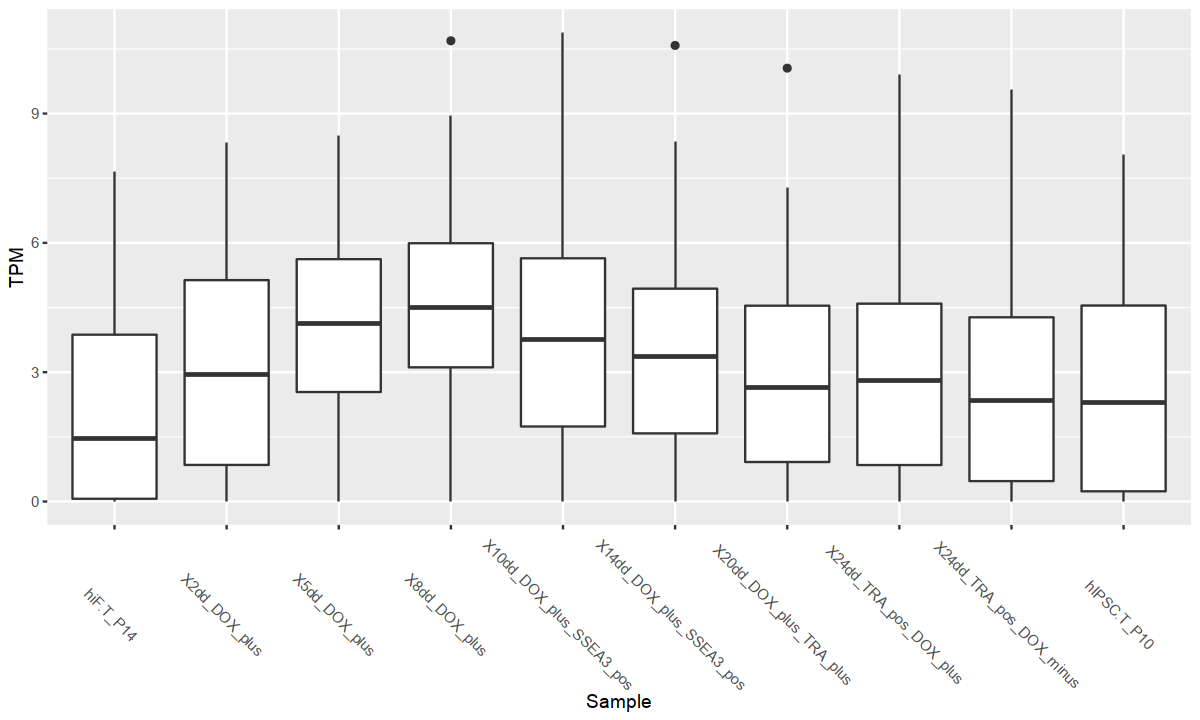

In [498]:
options(repr.plot.width = 10, repr.plot.height = 6)

ggplot(melt(as.matrix(log2(1+tpm)[rownames(tpm) %in% names(cor_genes)[1:100], ])), aes(x=Var2, y=value)) +
# ggplot(melt(t(scale(t(log2(1+tpm)[rownames(tpm) %in% names(cor_genes)[1:100], ])))), aes(x=Var2, y=value)) +
stat_boxplot() +
# geom_line(aes(group=Var1),size=0.1) + geom_point() +
theme(axis.text.x = element_text(angle = -45)) +
ylab("TPM") + xlab("Sample")
# geom_boxplot(outlier.shape = NA) + geom_jitter(width = 0.2)
# coord_cartesian(ylim=c(0,8))